# All Sites Random Forest
## Notebook #3
* random forest for cle elum only

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**


In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [3]:
import scipy

In [4]:
# Try opening 1 at a time, subsampling, then making a tidy dataset and closing
# ds_ce = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')
# ds_sr = xr.open_dataset('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')
# ds_fl = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

# Sample Dataset First 

#### We want to use a random forest generator to determine what best predictors for snow depth 
* ds.dah
* ds.dce
* ds.tpi

maybe, 
* ds.slope
* ds.aspect

### Cle Elum Ridge

We want to train the model on the full low elevation dataset, not just the rapid domain

In [246]:
ds

<xarray.Dataset>
Dimensions:                    (band: 1, y: 1388, x: 2564)
Coordinates:
  * x                          (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                          (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                       (band) int32 1
    spatial_ref                int32 0
Data variables: (12/42)
    hs_rapid_set1              (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set2              (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3              (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set2_maskpiles    (band, y, x) float32 nan nan nan ... nan nan nan
    hs_rapid_set3_maskpiles    (band, y, x) float32 nan nan nan ... nan nan nan
    chmws_rapid                (band, y, x) float32 nan nan nan ... nan nan nan
    ...                         ...
    chm_mask                   (band, y, x) float32 nan nan nan ... nan nan nan
    chmws_rapid_raw            (band, y, x) float32 nan nan nan ... nan nan nan
    hs_ncalm_model             (y, x, band) float64 nan nan nan ... nan nan nan
    hs_rapid_model             (y, x, band) float64 nan nan nan ... nan nan nan
    diff_hs_rapid_ncalm_model  (y, x, band) float64 nan nan nan ... nan nan nan
    diff_hs_rapid_ncalm        (band, y, x) float32 nan nan nan ... nan nan nan

In [247]:
# Read the dataset 1 at a time
ds = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')

# Flatten
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dah = ds.dah.values.flatten() 
ds_dce = ds.dce.values.flatten()
ds_tpi = ds.tpi.values.flatten() 
ds_slope = ds.slope.values.flatten()
ds_aspect = ds.aspect.values.flatten()
ds_dem = ds.dem.values.flatten()

# Subsample
num = 10

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 
ds_slope = ds_slope[::num]
ds_aspect = ds_aspect[::num]
ds_dem = ds_dem[::num]

# Create DF for the site 
df = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'slope': ds_slope,
                   'aspect': ds_aspect,
                   'dem': ds_dem,
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})


# random forest cannot have any na values
df.dropna(how='any', inplace=True) # it has to be everything 

# And close the large netcdf 
ds.close()

## Prepare the dataset for Random Forest Model

In [248]:
df_int = df.copy(deep=True)
df_int['snowdepth'] = df_int['snowdepth'].astype(float)
df_int['dah'] = df_int['dah'].astype(float)
df_int['dce'] = df_int['dce'].astype(float)
df_int['tpi'] = df_int['tpi'].astype(float)
df_int['slope'] = df_int['slope'].astype(float)
df_int['aspect'] = df_int['aspect'].astype(float)
df_int['dem'] = df_int['dem'].astype(float)

df_int.head()

,snowdepth,slope,aspect,dem,dah,tpi,dce
88289,0.545976,6.289164,74.695580,819.582886,-0.069476,-1.417273,-8.430352
88914,0.519857,6.615461,81.109093,819.417725,-0.060776,-1.731101,-6.593832
90788,0.899815,4.110511,65.775558,820.030823,-0.050407,-2.057611,-9.144000
91413,0.881211,3.138242,175.430603,820.017517,-0.046912,-2.017529,-7.315200
92038,0.654621,8.015234,60.913124,819.966675,-0.110427,-2.203366,-5.562078


In [249]:
# create the x, variables, columns
X = df_int.drop(columns=['snowdepth'])
X.head()

,slope,aspect,dem,dah,tpi,dce
88289,6.289164,74.695580,819.582886,-0.069476,-1.417273,-8.430352
88914,6.615461,81.109093,819.417725,-0.060776,-1.731101,-6.593832
90788,4.110511,65.775558,820.030823,-0.050407,-2.057611,-9.144000
91413,3.138242,175.430603,820.017517,-0.046912,-2.017529,-7.315200
92038,8.015234,60.913124,819.966675,-0.110427,-2.203366,-5.562078


In [250]:
# create the y, predictor, column
y = df_int.snowdepth
y.head()

88289    0.545976
88914    0.519857
90788    0.899815
91413    0.881211
92038    0.654621
Name: snowdepth, dtype: float64

In [251]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

False

## 1.  Random Forest

In [252]:
# number_model_runs = 1000 # for all random forest runs 
# number_model_runs = 50 # for testing right now 
number_model_runs = 500 # for testing right now 

In [216]:
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)

# parameters = {'n_estimators': [number_model_runs], 'max_depth':[3],}
#             #   'min_samples_split':[2000]} 
# clf1 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=15), parameters) #cv=3

# # trying to write it like this to get the n_jobs parameter to work 
# # clf1  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=4)

# clf1.fit(X=X_train1,y=y_train1.values.ravel())
# tree_model1 = clf1.best_estimator_ # only the GridSearchCV has the object "best_estimator_"

# y_pred_train1 = tree_model1.predict(X_train1)
# y_pred_test1 = tree_model1.predict(X_test1)
# print('Accuracy on training data is %.2f' % (accuracy_score(y_train1, y_pred_train1)))
# print('Accuracy on test data is %.2f' % (accuracy_score(y_test1, y_pred_test1)))
# print(clf1.best_params_)

In [253]:
# create test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create model 
# rf  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=15)
rf  = ensemble.RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=15)

# fit model 
rf.fit(X=X_train,y=y_train)

# predict
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# print accuracy
# print('Accuracy on training data is %.2f' % (accuracy_score(y_train, y_pred_train)))
# print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

In [220]:
# estimatorAccuracy=[]
# for curEstimator in range(number_model_runs):
#     estimatorAccuracy.append([curEstimator,accuracy_score(y.values, tree_model1.estimators_[curEstimator].predict(X.values))])

# estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
# estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

# bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

In [221]:
# tree.export_graphviz(bestDecisionTree1, out_file='ensemble_tree1.dot', 
#                 feature_names = X.columns,
#                 # class_names = ('no_veg', 'veg'),
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# from subprocess import call
# call(['dot', '-Tpng', 'ensemble_tree1.dot', '-o', 'ensemble_tree1.png', '-Gdpi=600'])

# from IPython.display import Image
# Image(filename = 'ensemble_tree1.png')

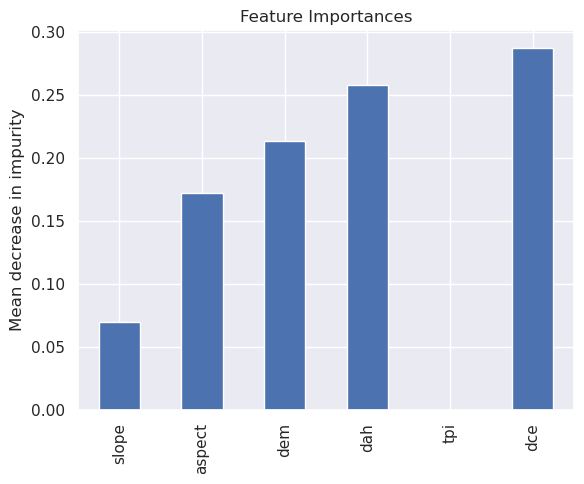

In [254]:
# Feature Importance 
importances1 = rf.feature_importances_
std1 = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X.columns)

fig, ax = plt.subplots(figsize=(6,5))
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Now, use the random forest model

Now we have the model, and we want to run it on the post treatment 

In [266]:
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros

In [267]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

In [268]:
ds_copy = ds.copy(deep=True)

In [269]:
# Read the dataset 1 at a time
ds_post = ds_copy.copy(deep=True)

# Flatten
post_snowdepth = ds_post.hs_rapid.values.flatten()
post_dah = ds_post.dah.values.flatten() 
post_dce = ds_post.dce_rapid.values.flatten()
post_tpi = ds_post.tpi.values.flatten() 
post_slope = ds_post.slope.values.flatten()
post_aspect = ds_post.aspect.values.flatten()
post_dem = ds_post.dem.values.flatten()

# Create df for the site 
df_post = pd.DataFrame({'snowdepth': post_snowdepth,
                   'slope': post_slope,
                   'aspect': post_aspect,
                   'dem': post_dem,
                   'dah': post_dah, 
                   'tpi': post_tpi,
                   'dce': post_dce,})

# random forest cannot have any na values
# df_post.dropna(how='any', inplace=True) # it has to be everything 

# instead of removing na, can we try filling it with something insane then removing those cells later?
df_post = df_post.fillna(100) 

In [270]:
# Read the dataset 1 at a time
# ds_pre = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')
ds_pre = ds_copy.copy(deep=True)

# Flatten
pre_snowdepth = ds_pre.hs_ncalm.values.flatten()
pre_dah = ds_pre.dah.values.flatten() 
pre_dce = ds_pre.dce_ncalm.values.flatten()
pre_tpi = ds_pre.tpi.values.flatten() 
pre_slope = ds_pre.slope.values.flatten()
pre_aspect = ds_pre.aspect.values.flatten()
pre_dem = ds_pre.dem.values.flatten()

# Create DF for the site 
df_pre = pd.DataFrame({'snowdepth': pre_snowdepth, 
                   'slope': pre_slope,
                   'aspect': pre_aspect,
                   'dem': pre_dem,
                   'dah': pre_dah, 
                   'tpi': pre_tpi,
                   'dce': pre_dce,})

# # random forest cannot have any na values
# df_pre.dropna(how='any', inplace=True) # it has to be everything 

# instead of removing na, can we try filling it with something insane then removing those cells later?
df_pre = df_pre.fillna(100) 

In [271]:
X_pre = df_pre.drop(columns=['snowdepth'])
X_post = df_post.drop(columns=['snowdepth'])
X_post.head()

,slope,aspect,dem,dah,tpi,dce
0,100.0,100.0,100.0,100.0,100.0,100.0
1,100.0,100.0,100.0,100.0,100.0,100.0
2,100.0,100.0,100.0,100.0,100.0,100.0
3,100.0,100.0,100.0,100.0,100.0,100.0
4,100.0,100.0,100.0,100.0,100.0,100.0


But, if they need to be integers, we need to check 

In [272]:
# # If they need to be integers for the model, then do this
df_pre_int = df_pre.copy(deep=True)
df_pre_int['snowdepth'] = df_pre_int['snowdepth'].astype(float)
df_pre_int['dah'] = df_pre_int['dah'].astype(float)
df_pre_int['dce'] = df_pre_int['dce'].astype(float)
df_pre_int['tpi'] = df_pre_int['tpi'].astype(float)

df_pre_int.head()

df_post_int = df_post.copy(deep=True)
df_post_int['snowdepth'] = df_post_int['snowdepth'].astype(float)
df_post_int['dah'] = df_post_int['dah'].astype(float)
df_post_int['dce'] = df_post_int['dce'].astype(float)
df_post_int['tpi'] = df_post_int['tpi'].astype(float)

df_post_int.head()

# create the x, variables, columns
X_pre = df_pre_int.drop(columns=['snowdepth'])
X_post = df_post_int.drop(columns=['snowdepth'])
X_post.head()

,slope,aspect,dem,dah,tpi,dce
0,100.0,100.0,100.0,100.0,100.0,100.0
1,100.0,100.0,100.0,100.0,100.0,100.0
2,100.0,100.0,100.0,100.0,100.0,100.0
3,100.0,100.0,100.0,100.0,100.0,100.0
4,100.0,100.0,100.0,100.0,100.0,100.0


Now, use the model to predict snow depth

In [273]:
hs_ncalm_model = rf.predict(X_pre)
hs_rapid_model = rf.predict(X_post)

In [274]:
ds['hs_ncalm_model'] = xr.DataArray(hs_ncalm_model.reshape(ds.dims['y'], ds.dims['x']), dims = ['y','x'])
ds['hs_rapid_model'] = xr.DataArray(hs_rapid_model.reshape(ds.dims['y'], ds.dims['x']), dims = ['y','x'])

In [275]:
# fill the model with nan where the obs is nan 
ds['hs_ncalm_model'] = ds['hs_ncalm_model'].where(ds['hs_ncalm'].notnull())
ds['hs_rapid_model'] = ds['hs_rapid_model'].where(ds['hs_rapid'].notnull())

In [276]:
ds['diff_hs_rapid_ncalm_model'] =  ds['hs_rapid_model'] - ds['hs_ncalm_model']

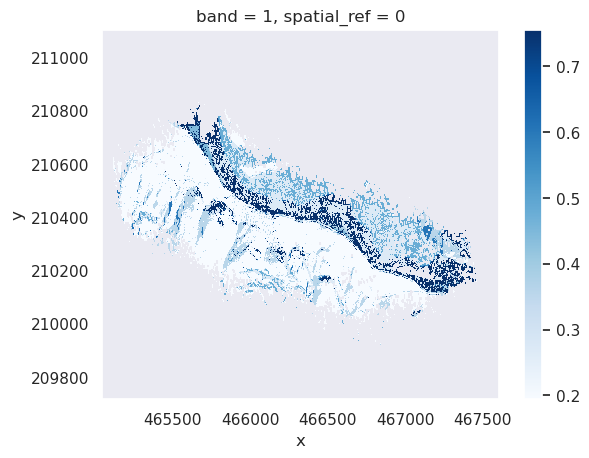

In [277]:
ds.hs_rapid_model.plot(cmap='Blues', cbar_kwargs={'label':''})

[]

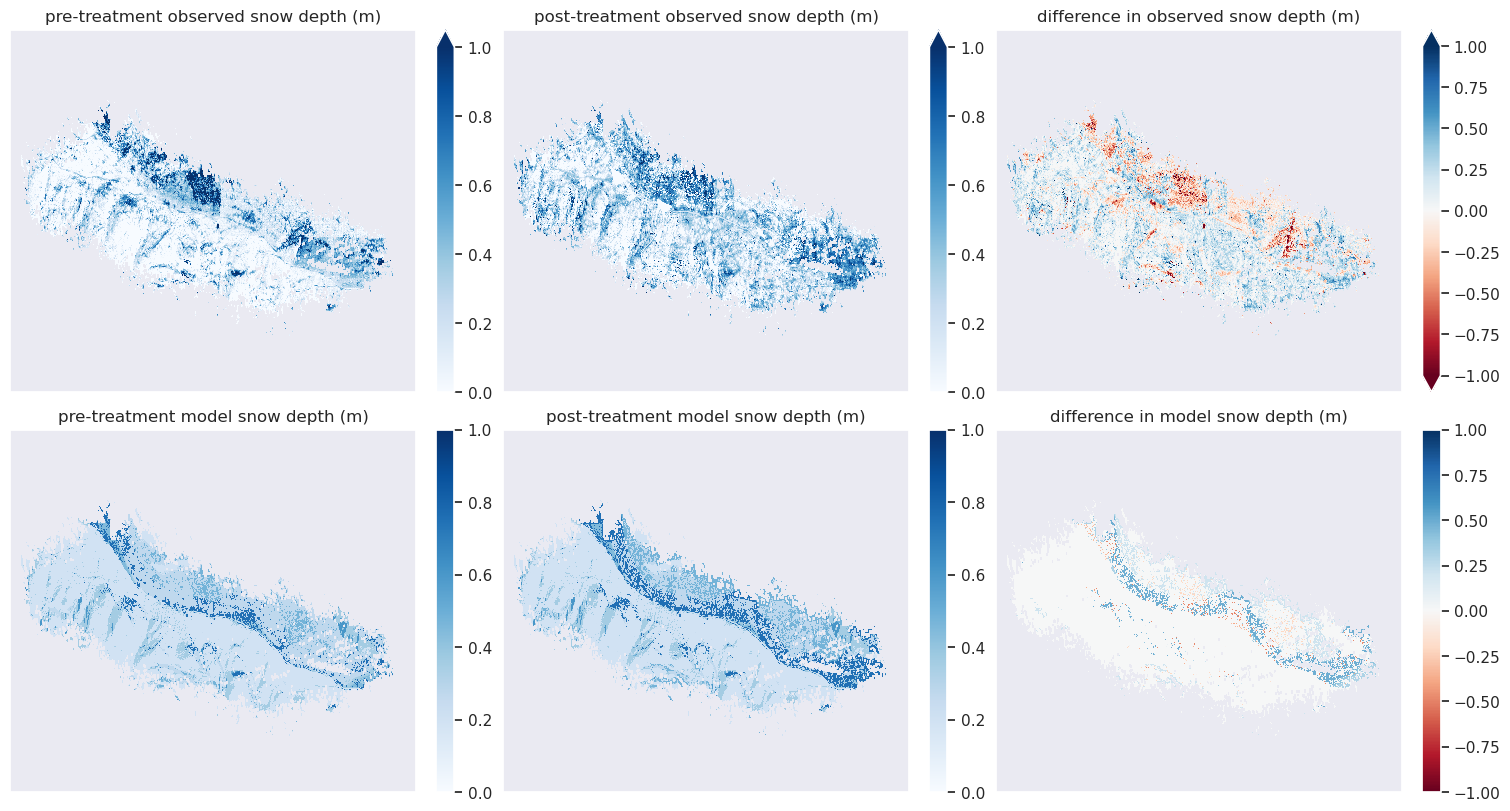

In [278]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)

# row 3 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']
ds.hs_ncalm.plot(ax=axes[0,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[0,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[0,0].set_title('pre-treatment observed snow depth (m)')
axes[0,1].set_title('post-treatment observed snow depth (m)')
axes[0,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[1,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment model snow depth (m)')
axes[1,1].set_title('post-treatment model snow depth (m)')
axes[1,2].set_title('difference in model snow depth (m)')

# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

In [282]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

# calculate the difference between the ncalm and rapid dce 
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

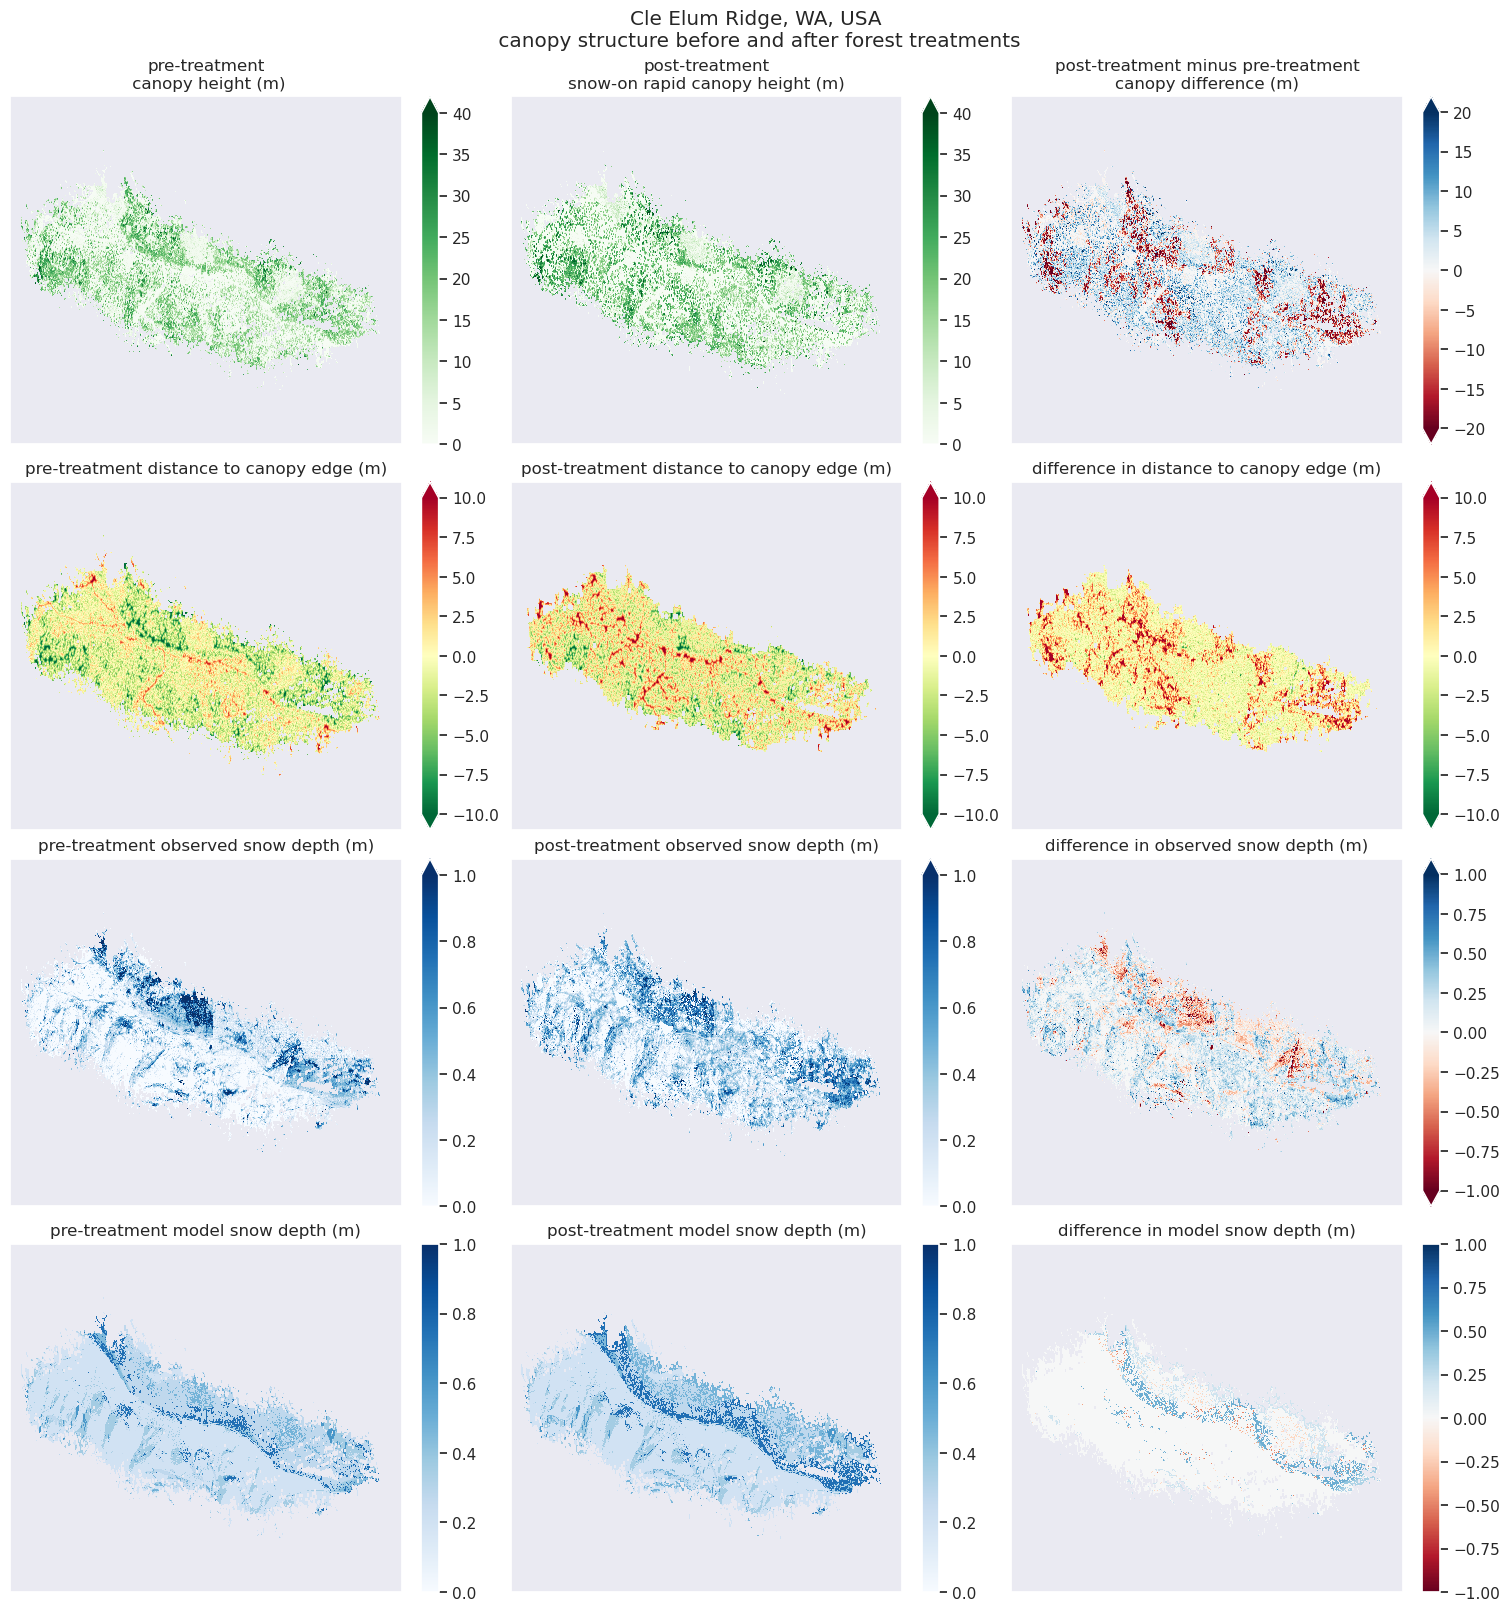

In [284]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[3,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[3,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[3,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])
plt.show()

Now, calculate the model skill for the final row in the plot 

In [287]:
# calclate model skill, perhaps she is looking for RMSE?
RMSE = np.sqrt(np.square(np.subtract(y_test,y_pred_test)).mean())
print('RMSE is %.2f' % (RMSE))

RMSE is 0.25


In [ ]:
# sklearn has a mean squared error 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

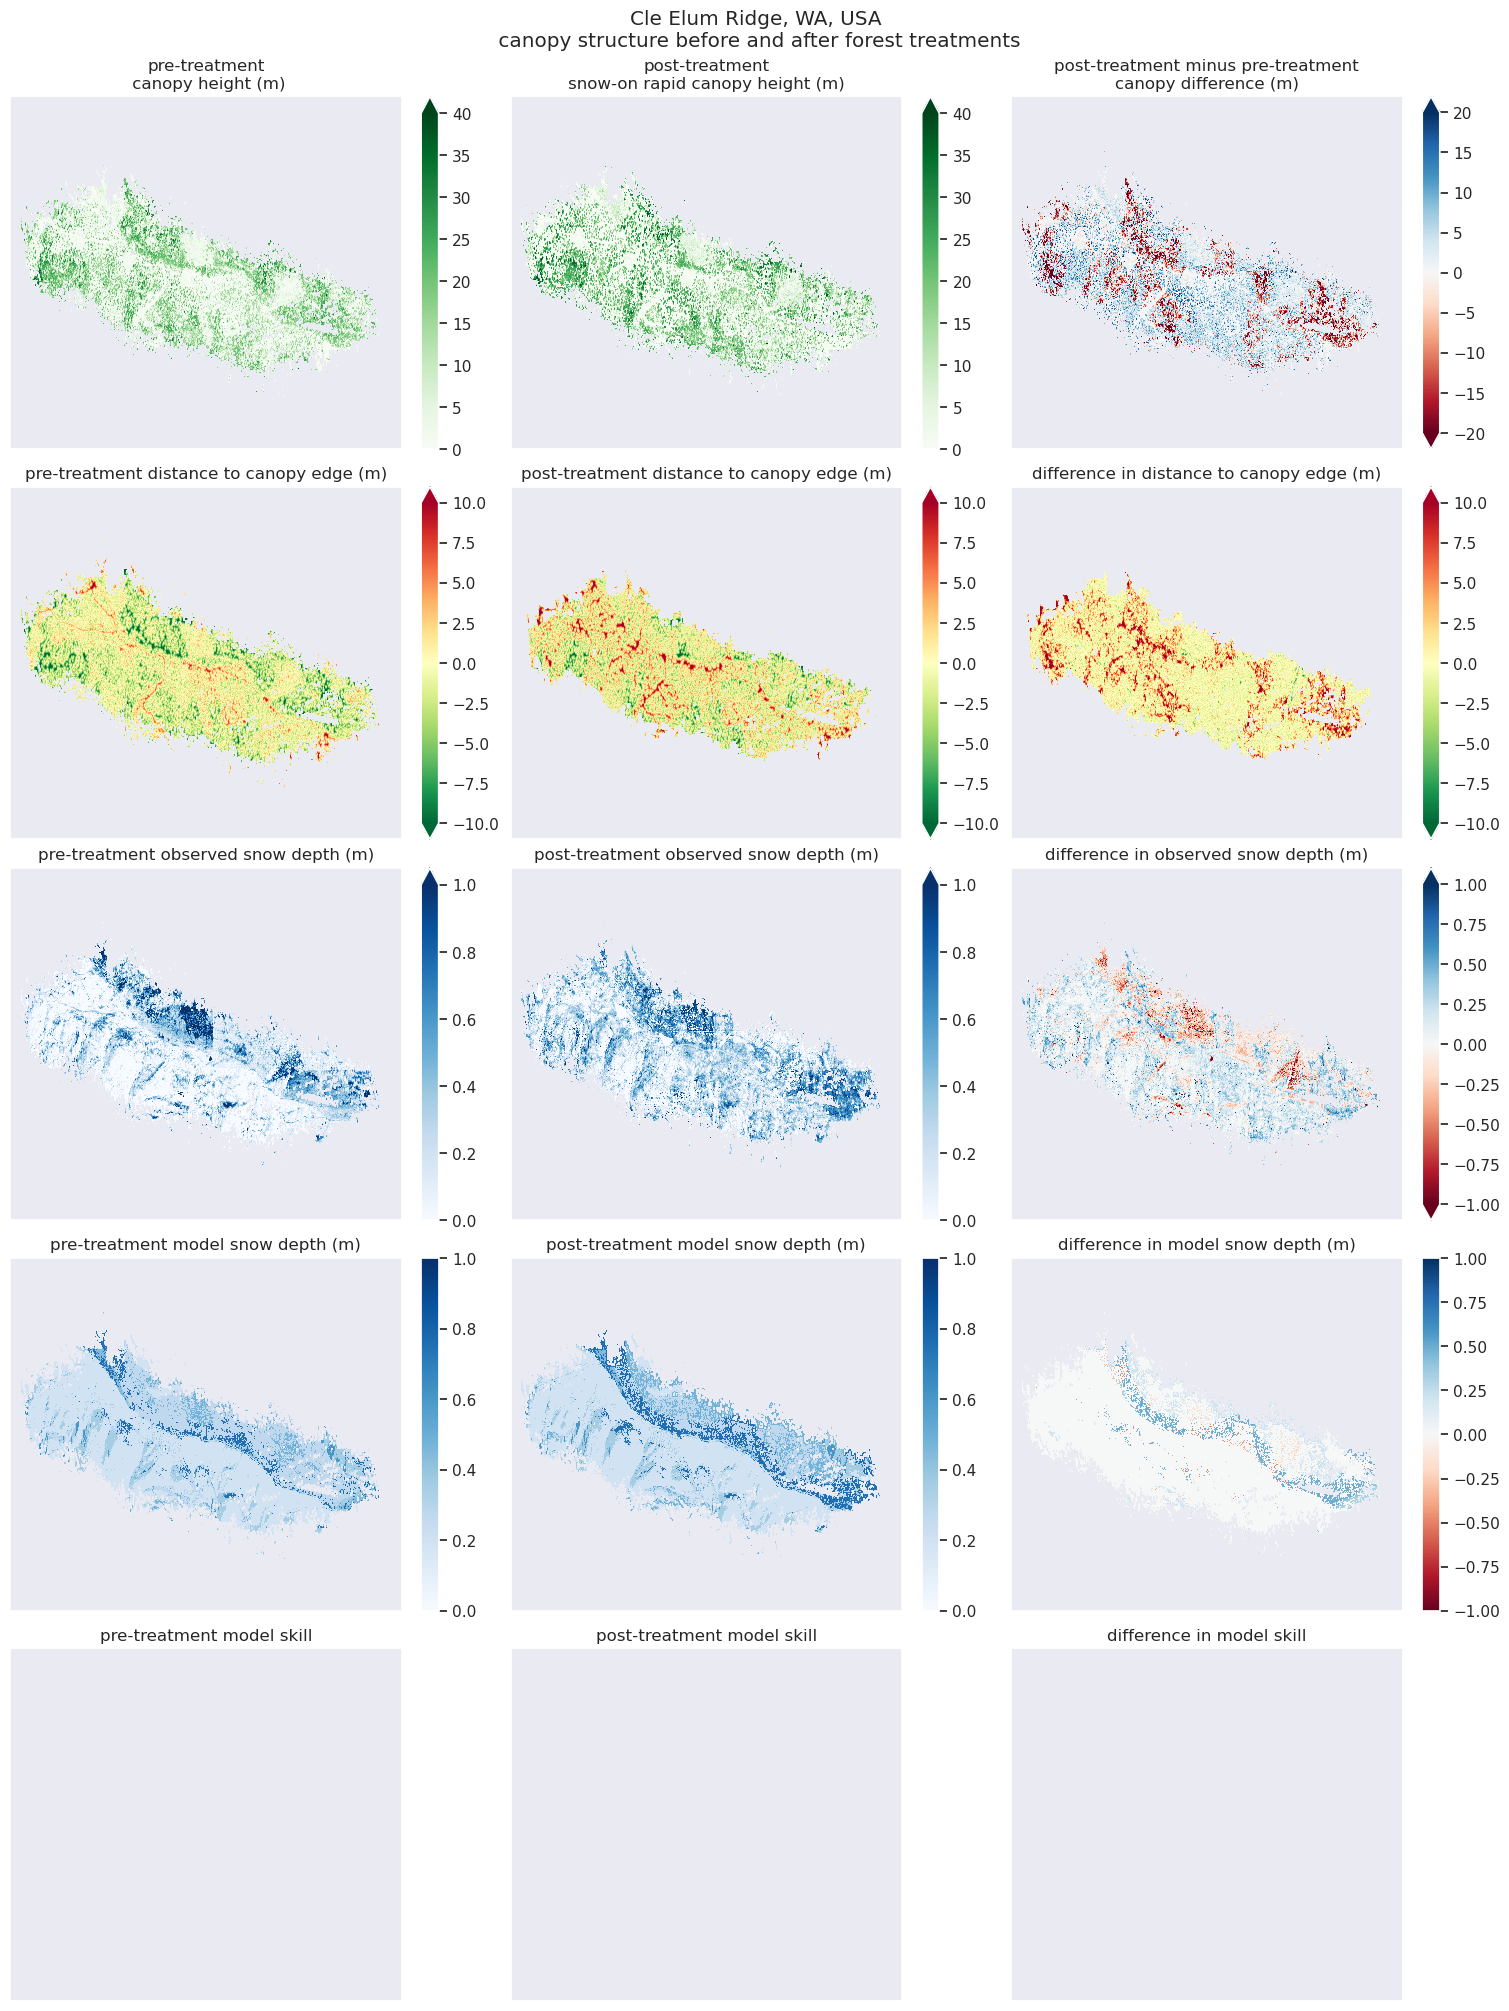

In [286]:
fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(15,20), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[3,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[3,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[3,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')

# row 5 (random forest model skill)
# ds.hs_ncalm_model.plot(ax=axes[3,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
# ds.hs_rapid_model.plot(ax=axes[3,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
# ds.diff_hs_rapid_ncalm_model.plot(ax=axes[3,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[4,0].set_title('pre-treatment model skill')
axes[4,1].set_title('post-treatment model skill')
axes[4,2].set_title('difference in model skill')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])

# row 5 
axes[4,0].set_xlabel(''); axes[4,0].set_ylabel(''); axes[4,0].set_xticks([]); axes[4,0].set_yticks([])
axes[4,1].set_xlabel(''); axes[4,1].set_ylabel(''); axes[4,1].set_xticks([]); axes[4,1].set_yticks([])
axes[4,2].set_xlabel(''); axes[4,2].set_ylabel(''); axes[4,2].set_xticks([]); axes[4,2].set_yticks([])
plt.show()

Save the model simulations for later 

In [285]:
filename = 'randomforest_regressor_model.pkl'
pickle.dump(rf, open(filename, 'wb')) # wb, writing 

# # loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 
# # result = loaded_model.score(X_test, y_test)
# # print(result)